# Twitter Sentiment Analysis by Ibrahim SEROUIS 💻

## What is Sentiment Analysis ? 🔍

Sentiment analysis is a natural language processing technique used to identify the emotional tone of pieces of writing. In most cases, goal is to determine whether the corpus is postive, negative or neutral. 

## What to expect 🤔

In this Notebook, we're going to train a Sentiment Analysis model on 1.6 million tweets extracted from the well-known Sentiment140 Dataset. 

# Libraries

In [1]:
# Regular expressions
import re

# Data and visualization 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculations
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Deep LEarning
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2022-04-16 08:51:14.656076: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Exploring the dataset 📊

# Load

In [2]:
dataset = pd.read_csv("/kaggle/input/twitter-sentiment-analysis-and-word-embeddings/Dataset/Dataset/training_dataset.csv", 
                      encoding="latin", 
                      header=None, 
                      names=["target","id","date","query","username","content"]
                     )

## Show some examples

In [3]:
dataset.head(5)

,target,id,date,query,username,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Check for missing values

In [4]:
print(f"Missing values: \n\n{dataset.isna().sum()}")

Missing values: 

target      0
id          0
date        0
query       0
username    0
content     0
dtype: int64




```
 There are 0 missing values within this dataset
```



## Target distribution 

### Negative samples : (*target = 0*) 😒

In [5]:
negative_samples = dataset[dataset["target"]==0]
print(f"Number of negative samples : {len(negative_samples)}\n")
negative_samples.head(5)

Number of negative samples : 800000



,target,id,date,query,username,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Neutral samples : (*target=2*) 😐

In [6]:
neutral_samples = dataset[dataset["target"]==2]
print(f"Number of neutral samples : {len(neutral_samples)}\n\n")
neutral_samples.head(5)

Number of neutral samples : 0




,target,id,date,query,username,content




```
0 neutral sample ? Wow
```



### Positive samples (*target=4*) 😄

In [7]:
positive_samples = dataset[dataset["target"]==4]
print(f"Number of positive samples {len(positive_samples)}\n\n")
positive_samples.head(5)

Number of positive samples 800000




,target,id,date,query,username,content
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800002,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800004,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


### Distribution plot

#### Defining data

In [8]:
data = [len(negative_samples), len(neutral_samples), len(positive_samples)]
labels = ["Negative","Neutral","Positive"]

#### Define color palette : See [seaborn color palettes](https://seaborn.pydata.org/tutorial/color_palettes.html)

In [9]:
colors = sns.color_palette("pastel")

#### Dsitribution pie chart

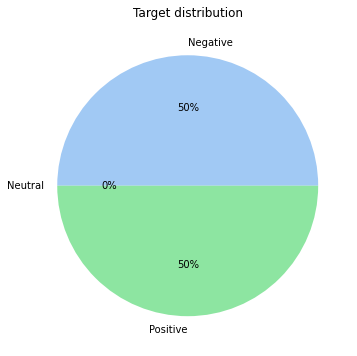

In [10]:
plt.figure(figsize=(6,6))
plt.title("Target distribution")
plt.pie(data, labels=labels, colors=colors, autopct="%.0f%%")
plt.show()

# Data cleaning 🧽🧼

## Drop unncessary columns
These columns are not necessary to train our model : ID, date, query, username. 

> Notes : 
- axis = 1 means "computing along the columns"
- using (inplace = true) will overwrite the existing dataframe

In [11]:
dataset.drop(["id","date","query","username"],axis=1, inplace=True)

### Result

In [12]:
dataset.head(5)

,target,content
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## Replace the targets 

In the original dataset, 4 means "true". For convenience purposes, we'll set it to 1. 

In [13]:
dataset.target = dataset.target.replace({4: 1})

### Result

In [14]:
dataset[dataset["target"]==1].head()

,target,content
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,Being sick can be really cheap when it hurts t...
800004,1,@LovesBrooklyn2 he has that effect on everyone


## Removing mentions, links, extra spaces from tweets

In [15]:
# Remove mentions
regex_mentions = r"@[A-Za-z0-9_]+"
# Remove links
regex_links = r"https?://[A-Za-z0-9./]+"
# Remove some special characters
regex_special = r"[^A-Za-z0-9]+"

### Apply preprocessing

In [16]:
# Remove mentions
dataset.content = dataset.content.apply(lambda x: re.sub(regex_mentions, " ", str(x).strip()))
# Remove links 
dataset.content = dataset.content.apply(lambda x: re.sub(regex_links, " ", str(x).strip()))
# Remove special characters
dataset.content = dataset.content.apply(lambda x: re.sub(regex_special, " ", str(x).strip()))

### Show results 

In [17]:
dataset.head(10)

,target,content
0,0,Awww that s a bummer You shoulda got David Ca...
1,0,is upset that he can t update his Facebook by ...
2,0,I dived many times for the ball Managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no it s not behaving at all i m mad why am i h...
5,0,not the whole crew
6,0,Need a hug
7,0,hey long time no see Yes Rains a bit only a bi...
8,0,nope they didn t have it
9,0,que me muera


## Check for null content after cleaning
In some rare cases, tweets may contain only special characters and end up "empty" after cleaning

In [18]:
print(f"Null values: \n\n{dataset.isna().sum()}")

Null values: 

target     0
content    0
dtype: int64


# Data preparation 👨🏾‍🔬

## Train/test split

Since the dataset is large enough, we will proceed to a 90-10 (90% for training and 10% for validation/test) split. 

> Note : Fixing the random state parameter makes our splitting operation reproductible by initializing the internal random number generator which will decide the splitting of data into train and test indices in our case. 

Inspired by [this answer](https://intellipaat.com/community/15379/python-random-state-in-splitting-dataset)


In [19]:
train, test = train_test_split(dataset, test_size=0.1, random_state=44)

### Results 

In [20]:
print(f"Training set length: {len(train)/1e6}M examples")
print(f"Test set length: {len(test)/1e6}M examples")

Training set length: 1.44M examples
Test set length: 0.16M examples


## Tokenization

Tokenization is the process of breaking apart original text into individual pieces (tokens) for further analysis. This process is important because the meaning of the text can be interpreted through analysis of the words present in the text. 

[Inspired from this medium article](https://medium.com/analytics-vidhya/spacy-basics-the-importance-of-tokens-in-natural-language-processing-89a698d8a76). 

### Define the tokenizer

This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf... [[source]](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer). 



In [21]:
# Initialize the tokenizer
tokenizer = Tokenizer()
# Updates the internal vocabulary based on our tweet contents
tokenizer.fit_on_texts(train.content)
# Setup the vocabular size based on the tokenizer results
vocab_size = len(tokenizer.word_index)+1

### Results 

In [22]:
print(f"Word index length: {len(tokenizer.word_index)}")
print(f"Some words: {list(tokenizer.word_index.keys())[0:10]}")

Word index length: 268198
Some words: ['i', 'to', 'the', 'a', 'my', 'it', 'and', 'you', 'is', 'in']


### Get the max token length

In [23]:
# Intialize the mex length to the first tweet length
max_length = len(dataset["content"][0].split())

# Loop through the tweets
for tweet in dataset["content"]: 
    # Get each tweet's length
    length = len(tweet.split())
    # Update the max length if greater
    if length > max_length: 
        max_length = length

print(f"Maximum token length: {max_length}")

Maximum token length: 53


## Define sequences

The Tensorlow "texts_to_sequences" method transforms each text in texts to a sequence of integers.

In [24]:
# Training set
sequences_train = tokenizer.texts_to_sequences(train.content)
# Test set
sequences_test = tokenizer.texts_to_sequences(test.content)

## Define the training and test sets

In [25]:
# Pad the training sequences to the same length after the sequence
X_train = pad_sequences(sequences_train, maxlen=max_length, padding="post")
# Pad the test sequences to the same length after the sequence
X_test = pad_sequences(sequences_test, maxlen=max_length, padding="post")

# Setup the training target
y_train = train.target.values
# Setup the test target values
y_test = test.target.values

print(f"Training test shape : {X_train.shape}")

Training test shape : (1440000, 53)


## Embedding with Word Embeddings (GloVe)

- Embedding is an approach that allows us to give a numeric representation of words. The Word Embeddings method setup words with similar meaning to have a similar representation. [Learn more here](https://www.geeksforgeeks.org/word-embeddings-in-nlp/)
- To sum up briefly, the GloVe dataset is a model for distributed word representation pre-trained on a very large corpus. Our GloVe dataset contains 100-dimensional pretrained words, with each row containing the actual word followed by its 100-dimensional representation. 

### Setup embeddings

In [26]:
embeddings_dictionary = dict()
embedding_dimension = 100
glove_file = open("/kaggle/input/twitter-sentiment-analysis-and-word-embeddings/Dataset/Dataset/word_embeddings.txt")

### Apply word embedding

In [27]:
# Iterate through the glove file
for line in glove_file:
    # Split each line
    records = line.split()
    # Get the actual word
    word = records[0]
    # Get the dimensional representation
    representation = np.asarray(records[1:], dtype="float32")
    # Update the words dictionary 
    embeddings_dictionary[word] = representation
    
# Close the file
glove_file.close()

# Initialize the embedding_matrix
embeddings_matrix = np.zeros((vocab_size, embedding_dimension))

# Iterate through the tokenizer words list
for word, index in tokenizer.word_index.items():
    # Get the word representation
    embedding_vector = embeddings_dictionary.get(word)
    # Update the word representation if it exist in our dictionary
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

# Define the model 🔧

## Set the training parameters

In [28]:
num_epochs = 50
batch_size = 1000

## Define the embedding layer

In [29]:
embedding_layer = Embedding(
                            vocab_size, 
                            embedding_dimension, 
                            input_length=max_length, 
                            weights=[embeddings_matrix], 
                            trainable=False
)

## Define the callback : Early Stopping

We setup the Early Stopping callback to stop the training process if the **validation accuracy** stops increasing after 10 epochs, and restore the weights which minimize the validation accuracy. 

Important parameters :

- **Monitor :** keras will stop training when the monitored metric has stopped improving. The direction (minimze or maximize) is automatically infered from the monitored quantity name, although it remains adjustable with the "mode" parameter
- **Patience :** the number of epochs without improvement after which the callback will be triggered (i.e, the model will stop training)
- **Restore best weights :** tells the model to restore the weights from the "best" epoch according to the monitored value

In [30]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", 
    patience=10, 
    mode ="max", 
    verbose=2, 
    restore_best_weights=True
)

## Create the model

Architecture : 

### The embedding layer defined before

### 3 Bidirectional LSTM layers followed by dropout layers

To sum up : 
- **LSTM layers** are an RNN architecture used to keep track of arbitrary long-term dependencies in the input sequences. The bidirectional version fits well in our context where each sequence (word) can be related to the previous or the next one to grasp the full meaning of the sentence.
- **Dropout** prevents overfitting by randomly dropping neurons

### Two fully-connected (dense) layers

In [31]:
model = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(units=128, return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(LSTM(units=128, return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(LSTM(units=128)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

2022-04-16 08:53:14.816232: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-16 08:53:14.819440: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-16 08:53:14.882999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 08:53:14.883738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-04-16 08:53:14.883800: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-04-16 08:53:14.912651: I tensorflow/stream_executor/platform/def

## Compile the model

> Notes : The binary cross entropy loss suits well to our binary classification case (two targets : positive or negative)

In [32]:
model.compile(
       optimizer = Adam(learning_rate=0.001),
       loss="binary_crossentropy", 
       metrics=["accuracy"]
  )

## Model summary 

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 53, 100)           26819900  
_________________________________________________________________
bidirectional (Bidirectional (None, 53, 256)           234496    
_________________________________________________________________
dropout (Dropout)            (None, 53, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 53, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

## Plot the model architecture

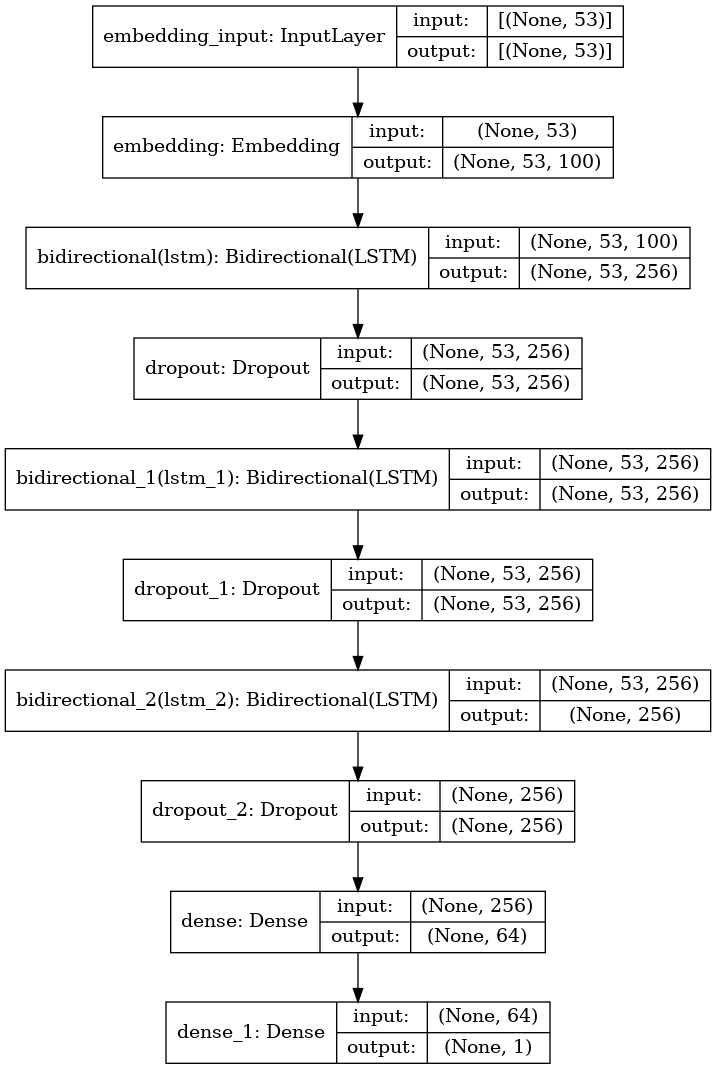

In [34]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Train the model ⚗️

In [35]:
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=1, 
    validation_data=(X_test,y_test),
    callbacks = [stop_early]
)

2022-04-16 08:53:21.385426: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-16 08:53:21.394585: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000129999 Hz


Epoch 1/50


2022-04-16 08:53:26.725844: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-04-16 08:53:27.468088: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-04-16 08:53:27.530210: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1440/1440 [==============================] - 175s 113ms/step - loss: 0.5146 - accuracy: 0.7414 - val_loss: 0.4350 - val_accuracy: 0.7969
Epoch 2/50
1440/1440 [==============================] - 161s 112ms/step - loss: 0.4265 - accuracy: 0.8024 - val_loss: 0.4169 - val_accuracy: 0.8074
Epoch 3/50
1440/1440 [==============================] - 161s 112ms/step - loss: 0.4044 - accuracy: 0.8146 - val_loss: 0.4000 - val_accuracy: 0.8159
Epoch 4/50
1440/1440 [==============================] - 161s 112ms/step - loss: 0.3889 - accuracy: 0.8231 - val_loss: 0.3899 - val_accuracy: 0.8228
Epoch 5/50
1440/1440 [==============================] - 161s 112ms/step - loss: 0.3773 - accuracy: 0.8297 - val_loss: 0.3883 - val_accuracy: 0.8249
Epoch 6/50
1440/1440 [==============================] - 161s 112ms/step - loss: 0.3663 - accuracy: 0.8360 - val_loss: 0.3798 - val_accuracy: 0.8286
Epoch 7/50
1440/1440 [==============================] - 161s 112ms/step - loss: 0.3580 - accuracy: 0.8396 - val_loss: 0.383

# Save the model  💾

 ## Define the text vectorization layer for inferences

In [36]:
# Setup the vocabulary
vocabulary = list(tokenizer.word_index.keys())

In [37]:
# Get the input shape
input_shape = tf.keras.Input(shape=(max_length))
shape = input_shape.shape
print(f"Model input shape: {shape}")

Model input shape: (None, 53)


In [38]:
# Create the text vectorization layer
vectorize_layer = TextVectorization (
    # Standardization to apply to the input text
    standardize="lower_and_strip_punctuation",
    # Maximum size of the vocabulary for this layer
    max_tokens=vocab_size+1,
    # Output of the layer 
    output_mode="int",
    output_sequence_length=max_length, 
    vocabulary=vocabulary
)

# Adapt to our training content
vectorize_layer.adapt(train["content"].values)

## Define the export model

Export model : **Input Layer ---> Vectorization Layer ---> Our trained model ---> The activation layer (score)**

In [39]:
export_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1,), dtype=tf.string),
    vectorize_layer,
    model,
    tf.keras.layers.Activation("sigmoid")
])

## Compile the export model

In [40]:
export_model.compile(
       optimizer = Adam(learning_rate = 0.001),
       loss="binary_crossentropy", 
       metrics=["accuracy"]
)

## Save the export model

In [41]:
export_model.save("TSA_model_v4")

2022-04-16 09:45:01.131832: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Plot the results 📊

In [42]:
number_of_epochs = len(history.history["loss"])
print(f"Number of epochs: {number_of_epochs}")

Number of epochs: 18


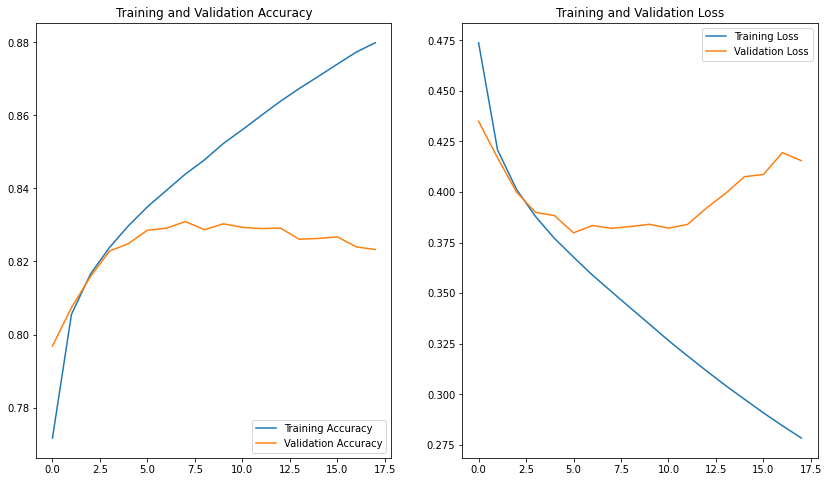

Maximum validation accuracy:  0.8309249877929688
Minimum loss: 0.3820512592792511


In [43]:
# Get the accuracy results for each epoch
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
# Get the loss results for each epoch
loss = history.history["loss"]
val_loss = history.history["val_loss"]
# Get the epochs count
epochs_range = range(len(history.history["loss"]))

# Create the plot area
plt.figure(figsize=(14, 8))

# Setup the first colum : Accuracy plot
plt.subplot(1, 2, 1)
# Plot the training and validation accuracy for these epochs
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
# Setup the legend
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

# Setup the second colum : Loss plot
plt.subplot(1, 2, 2)
# Plot the training and validation loss for these epochs
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
# Setup the legend
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

# Show the overall plot
plt.show()

position = np.argmax(history.history["val_accuracy"])
print(f"Maximum validation accuracy:  {history.history['val_accuracy'][position]}\nMinimum loss: {history.history['val_loss'][position]}")

In [44]:
best_accuracy = max(history.history["val_accuracy"])
print(f"Best validation accuracy : {best_accuracy}")

Best validation accuracy : 0.8309249877929688


## Print the classification report

In [45]:
predictions = model.predict(X_test)
predictions = np.where(predictions<0.5, 0, 1)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83     79800
           1       0.82      0.84      0.83     80200

    accuracy                           0.83    160000
   macro avg       0.83      0.83      0.83    160000
weighted avg       0.83      0.83      0.83    160000



## Test

In [46]:
# Sample sentence
examples = ["being sick can be really cheap when it hurts too much to eat real food plus your friends make you soup"]
# Display the example
print("Examples: ", examples, " Type: ", type(examples))
# Predict and display the score
export_model.predict(examples)

Examples:  ['being sick can be really cheap when it hurts too much to eat real food plus your friends make you soup']  Type:  <class 'list'>


array([[0.68351]], dtype=float32)

# Tune the threshold (experimental) ⚗️

In [47]:
predictions = model.predict(X_test)

## Calculate the best f1 score for each threshold

In [48]:
# Generate an array from 0 to 1 with a 0.001 step
thresholds = np.arange(0, 1, 0.001)
thres_pos = 0.1
f1_score = 0.001

### Positive threshold

In [49]:
# Loop trough the tresholds array
for threshold in thresholds :
    # Get the positive predictions
    prediction = np.where(predictions>threshold, 1, 0)
    # Generate the classification report 
    report = classification_report(y_test, prediction, output_dict=True)
    # Get the F1-score from the report
    f1_score_new = report["1"]["f1-score"]
    # Update the final F1-score if greater
    if f1_score_new > f1_score: 
        f1_score = f1_score_new
        thres_pos = threshold

# Display the results
print(f"Best threshold : {thres_pos} \nBest f1_score: {f1_score}")

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best threshold : 0.423 
Best f1_score: 0.8349145204858647


### Negative threshold

In [50]:
thres_neg = 0.1
f1_score_neg = 0.001

# Loop trough the tresholds array
for threshold in thresholds :
    # Get the positive predictions
    prediction = np.where(predictions>threshold, 1, 0)
    # Generate the classification report 
    report = classification_report(y_test, prediction, output_dict=True)
    # Get the F1-score from the report
    f1_score_new = report["0"]["f1-score"]
    # Update the final F1-score if greater
    if f1_score_new > f1_score_neg: 
        f1_score_neg = f1_score_new
        thres_neg = threshold

# Display the results
print(f"Best threshold : {thres_neg} \nBest f1_score: {f1_score_neg}")

Best threshold : 0.625 
Best f1_score: 0.8340107299626078


## Test

In [51]:
examples = [ "this is a very good day, don't you think so ?" ]

print(f"Examples: {examples} Type: {type(examples)}")

results = np.max(export_model.predict(examples))

final_threshold = thres_neg if thres_neg>thres_pos else thres_pos

if results >= final_threshold: 
    print("Positive (^_^)")
else: 
    print("Negative (>_<)")

Examples: ["this is a very good day, don't you think so ?"] Type: <class 'list'>
Positive (^_^)
